In [1]:
using JuMP,Plots,Ipopt

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    19324
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   107858

Total number of variables............................:     2401
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1601
                     variables with only upper bounds:        0
Total numb

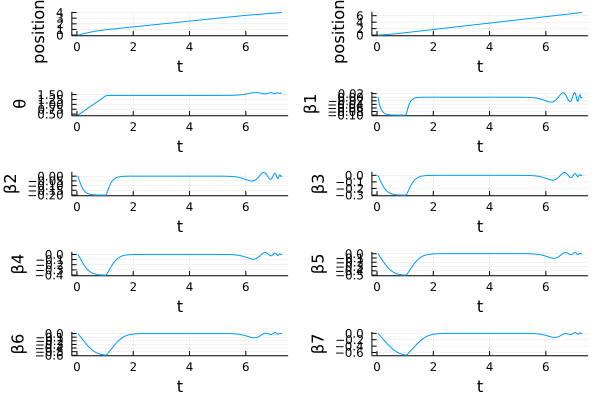

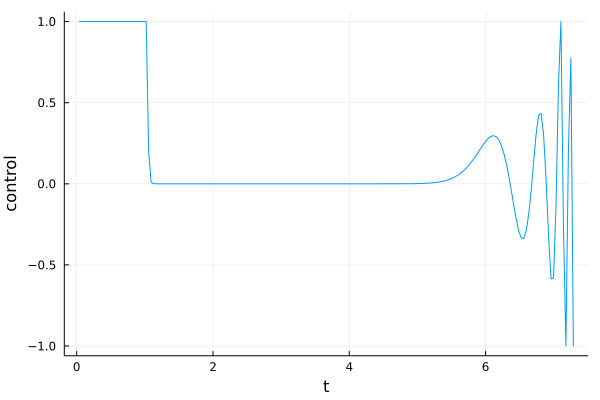

0.036439626792596456
tf = 7.28767864551622


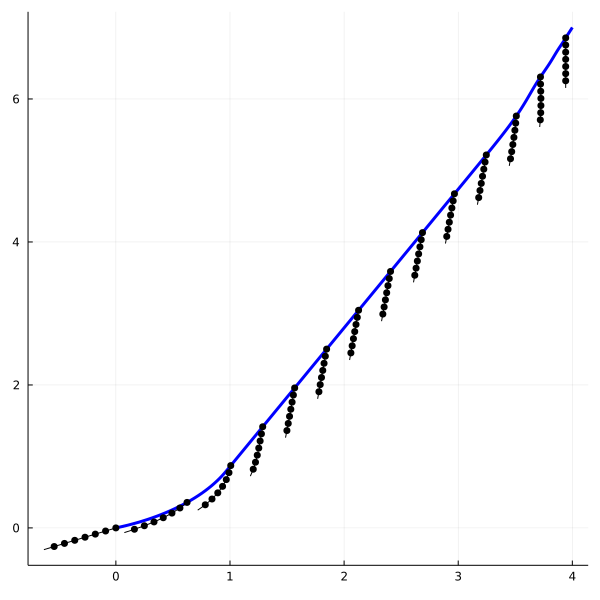

In [2]:
#JuMP model, Ipopt solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys,"tol",1e-14)
set_optimizer_attribute(sys,"max_iter",1000)

#Parameters

# constants
w = 0.4
l = 0.1   # l must respect the condiction : l <= 1/sqrt(N), where N is the number of segments, typically here N = 7, so 0 <= l <= 1/sqrt(7) 
μ = 10^(-6)

# function wich gives the bound for each alpha_k 

function bound(k)
    α_star = asin(l/sqrt(1-(k-1)*l^2))
    return α_star
end

# function wich gives the bound for each beta_k 

function sum_bounds(k)
    s = 0 
    for i = 1 : k 
        s+= bound(i)
    end
    return s
end
     

# initial data
x0 = 0 
y0 = 0 
θ0 = π/7
β1_0 = 0 
β2_0 = 0
β3_0 = 0
β4_0 = 0
β5_0 = 0
β6_0 = 0
β7_0 = 0
c0 = 0

# final data
xf = 4
yf = 7
θf = π/2
β1_f = 0
β2_f = 0
β3_f = 0
β4_f = 0
β5_f = 0
β6_f = 0
β7_f = 0

P = 200
# Bounds for variables

JuMP.@variables(sys,begin
    x[1:P]                                  # x 
    y[1:P]                                  # y 
    θ[1:P]                                  # theta
    -sum_bounds(1)≤β1[1:P]≤sum_bounds(1)    # beta1         -alpha*_i + beta_{i-1} <= beta_i <= alpha*_i + beta_{i-1}
    -sum_bounds(2)≤β2[1:P]≤sum_bounds(2)    # beta2
    -sum_bounds(3)≤β3[1:P]≤sum_bounds(3)    # beta3
    -sum_bounds(4)≤β4[1:P]≤sum_bounds(4)    # beta4
    -sum_bounds(5)≤β5[1:P]≤sum_bounds(5)    # beta5
    -sum_bounds(6)≤β6[1:P]≤sum_bounds(6)    # beta6
    -sum_bounds(7)≤β7[1:P]≤sum_bounds(7)    # beta7
    -1 ≤ u[1:P] ≤ 1                         # u, control
     0 ≤ Δt ≤ 1
    c[1:P]
    end)


# Objective
@objective(sys,Min,Δt+μ*c[P])
# Constraints 
@constraints(sys,begin
    x[1] == x0
    y[1] == y0
    θ[1] == θ0
    β1[1]== β1_0
    β2[1] == β2_0
    β3[1] == β3_0
    β4[1] == β4_0
    β5[1] == β5_0
    β6[1] == β6_0
    β7[1] == β7_0
    c[1] == c0
    x[P] == xf
    y[P] == yf
    θ[P] == θf
    β1[P] == β1_f
    β2[P] == β2_f
    β3[P] == β3_f
    β4[P] == β4_f
    β5[P] == β5_f
    β6[P] == β6_f
    β7[P] == β7_f
        end)

# Dynamics : Crank-Nicolson scheme
for j in 1 : P-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt * (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt * (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
    @NLconstraint(sys, #beta3' = -u - cos(beta1) * cos(beta2-beta1)*sin(beta3 - beta2)/l
        β3[j+1] == β3[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j]) * sin(β3[j] - β2[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1]) * sin(β3[j+1] - β2[j+1])/l ))
    @NLconstraint(sys, #beta4' = -u - cos(beta1) * cos(beta2-beta1)*cos(beta3-beta2)*sin(beta4 - beta3)/l
        β4[j+1] == β4[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j])*cos(β3[j] - β2[j]) * sin(β4[j] - β3[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1])*cos(β3[j+1] - β2[j+1])* sin(β4[j+1] - β3[j+1])/l ))
    @NLconstraint(sys, #beta5' = -u - cos(beta1) * cos(beta2-beta1)*cos(beta3-beta2)*cos(beta4-beta3)*sin(beta5 - beta4)/l
        β5[j+1] == β5[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j])*cos(β3[j] - β2[j]) *cos(β4[j]-β3[j])* sin(β5[j] - β4[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1])*cos(β3[j+1] - β2[j+1])*cos(β4[j+1]-β3[j+1])* sin(β5[j+1] - β4[j+1])/l ))
    @NLconstraint(sys, #beta6' = -u - cos(beta1) * cos(beta2-beta1)*cos(beta3-beta2)*cos(beta4-beta3)*cos(beta5-beta4)*sin(beta6 - beta5)/l
        β6[j+1] == β6[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j])*cos(β3[j] - β2[j]) *cos(β4[j]-β3[j])*cos(β5[j]-β4[j])* sin(β6[j] - β5[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1])*cos(β3[j+1] - β2[j+1])*cos(β4[j+1]-β3[j+1])*cos(β5[j+1]-β4[j+1])* sin(β6[j+1] - β5[j+1])/l ))
    @NLconstraint(sys, #beta7' = -u - cos(beta1) * cos(beta2-beta1)*cos(beta3-beta2)*cos(beta4-beta3)*cos(beta5-beta4)*cos(beta6-beta5)*sin(beta7 - beta6)/l
        β7[j+1] == β7[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j])*cos(β3[j] - β2[j]) *cos(β4[j]-β3[j])*cos(β5[j]-β4[j])*cos(β6[j]-β5[j])* sin(β7[j] - β6[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1])*cos(β3[j+1] - β2[j+1])*cos(β4[j+1]-β3[j+1])*cos(β5[j+1]-β4[j+1])*cos(β6[j+1]-β5[j+1])* sin(β7[j+1] - β6[j+1])/l ))
    @NLconstraint(sys, # L2-norm regularization on the control
        c[j+1] == c[j] + 0.5 * Δt * (u[j]^2+ u[j+1]^2))

    
end

@NLconstraint(sys,p_t[j = 1:(P-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 * Δt * (u[j] + u[j+1]) )


#Solve for the control and state
println("Solving...")
status = optimize!(sys)
println("Solver status : ",status)
x1 = value.(x)
y1 = value.(y)
θ1 = value.(θ)
β_1 = value.(β1)
β_2 = value.(β2)
β_3 = value.(β3)
β_4 = value.(β4)
β_5 = value.(β5)
β_6 = value.(β6)
β_7 = value.(β7)
u1 = value.(u)
println("Cost : " , objective_value(sys))

println("tf = ", value.(Δt)*P)

#plots : states 

Δt1 = value.(Δt)
t = (1 : P)*Δt1


x_plot = plot(t,x1,xlabel = "t", ylabel = "position x", legend = false, fmt = :png)
y_plot = plot(t,y1,xlabel = "t", ylabel = "position y", legend = false, fmt = :png)
θ_plot = plot(t,θ1,xlabel = "t", ylabel = "θ", legend = false, fmt = :png)
β1_plot = plot(t,β_1,xlabel = "t", ylabel = "β1", legend = false, fmt = :png)
β2_plot = plot(t,β_2,xlabel = "t", ylabel = "β2", legend = false, fmt = :png)
β3_plot = plot(t,β_3,xlabel = "t", ylabel = "β3", legend = false, fmt = :png)
β4_plot = plot(t,β_4,xlabel = "t", ylabel = "β4", legend = false, fmt = :png)
β5_plot = plot(t,β_5,xlabel = "t", ylabel = "β5", legend = false, fmt = :png)
β6_plot = plot(t,β_6,xlabel = "t", ylabel = "β6", legend = false, fmt = :png)
β7_plot = plot(t,β_7,xlabel = "t", ylabel = "β7", legend = false, fmt = :png)
display(plot(x_plot,y_plot,θ_plot,β1_plot,β2_plot,β3_plot,β4_plot,β5_plot,β6_plot,β7_plot,layout = (5,2)))
u_plot = plot(t,u1,xlabel = "t", ylabel = "control", legend = false, fmt = :png)
display(u_plot)

#plots : trajectory 

p = plot(x1,y1, c = :blue, lw = 3)
plot!(size=(600,600))

for i = 1 :15 : P 
    z = [x1[i] y1[i]]
    θ_p = θ1[i]
    β1_p = β_1[i]
    β2_p = β_2[i]
    β3_p = β_3[i]
    β4_p = β_4[i]
    β5_p = β_5[i]
    β6_p = β_6[i]
    β7_p = β_7[i]
    
    θ_1 =  β1_p + θ_p
    θ_2 =  β2_p + θ_p
    θ_3 =  β3_p + θ_p
    θ_4 =  β4_p + θ_p
    θ_5 =  β5_p + θ_p
    θ_6 =  β6_p + θ_p
    θ_7 =  β7_p + θ_p

    z1 = z - l*[cos(θ_1) sin(θ_1)]
    z2 = z1 - l*[cos(θ_2) sin(θ_2)]
    z3 = z2 - l*[cos(θ_3) sin(θ_3)]
    z4 = z3 - l*[cos(θ_4) sin(θ_4)]
    z5 = z4 - l*[cos(θ_5) sin(θ_5)]
    z6 = z5 - l*[cos(θ_6) sin(θ_6)]
    z7 = z6 - l*[cos(θ_7) sin(θ_7)]


    
    plot!([z[1],z1[1]], [z[2],z1[2]] ,color=:black, legend = false)
    plot!([z1[1],z2[1]], [z1[2],z2[2]], color=:black, legend = false)
    plot!([z2[1],z3[1]], [z2[2],z3[2]], color=:black, legend = false)
    plot!([z3[1],z4[1]], [z3[2],z4[2]], color=:black, legend = false)
    plot!([z4[1],z5[1]], [z4[2],z5[2]], color=:black, legend = false)
    plot!([z5[1],z6[1]], [z5[2],z6[2]], color=:black, legend = false)
    plot!([z6[1],z7[1]], [z6[2],z7[2]], color=:black, legend = false)
    
    plot!([z[1]],[z[2]],seriestype = :scatter, color =:black , legend = false)
    plot!([z1[1]],[z1[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z2[1]],[z2[2]],seriestype = :scatter, color =:black , legend = false)
    plot!([z3[1]],[z3[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z4[1]],[z4[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z5[1]],[z5[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z6[1]],[z6[2]],seriestype = :scatter, color =:black , legend = false) 

    plot!(size=(600,600))
end
current()

Solving...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    19324
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   107858

Total number of variables............................:     2401
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1601
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2210
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr

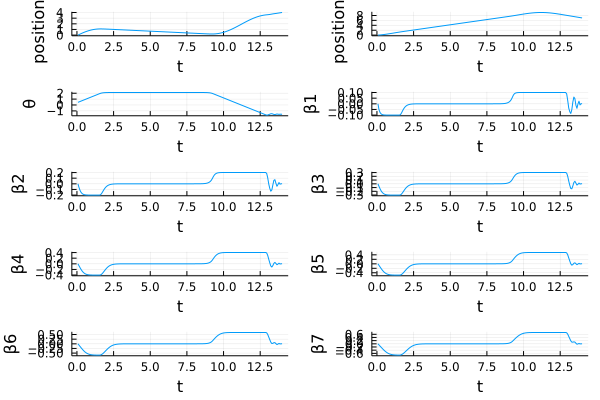

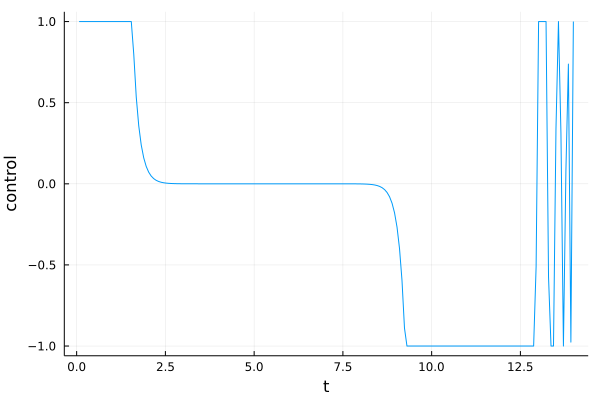


Cost : 0.07056689581563906
tf = 13.991799166687615


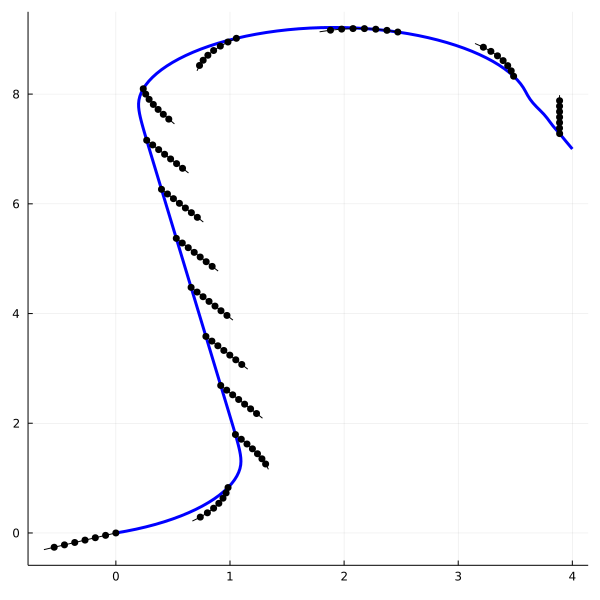

In [3]:
#JuMP model, Ipopt solver
sys2 = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys2,"tol",1e-14)
set_optimizer_attribute(sys2,"max_iter",1000)

#Parameters

# constants
w = 0.4
l = 0.1   # l must respect the condiction : l<= 1/sqrt(N), where N is the number of segments, typically here N = 7, so 0 <= l <= 1/sqrt(7) 
μ = 10^(-4)

# function wich gives the bound for each alpha_k 

function bound(k)
    α_star = asin(l/sqrt(1-(k-1)*l^2))
    return α_star
end

# function wich gives the bound for each beta_k 

function sum_bounds(k)
    s = 0 
    for i = 1 : k 
        s+= bound(i)
    end
    return s
end

# initial data
x0 = 0 
y0 = 0 
θ0 = π/7
β1_0 = 0 
β2_0 = 0
β3_0 = 0
β4_0 = 0
β5_0 = 0
β6_0 = 0
β7_0 = 0
c0 = 0

# final data
xf = 4
yf = 7
θf = -π/2
β1_f = 0
β2_f = 0
β3_f = 0
β4_f = 0
β5_f = 0
β6_f = 0
β7_f = 0

P = 200
# Bounds for variables

JuMP.@variables(sys2,begin
    x[1:P]                                   # x 
    y[1:P]                                   # y 
    θ[1:P]                                   # theta
    -sum_bounds(1)≤β1[1:P]≤sum_bounds(1)     # beta1         -alpha*_i + beta_{i-1} <= beta_i <= alpha*_i + beta_{i-1}
    -sum_bounds(2)≤β2[1:P]≤sum_bounds(2)     # beta2
    -sum_bounds(3)≤β3[1:P]≤sum_bounds(3)     # beta3
    -sum_bounds(4)≤β4[1:P]≤sum_bounds(4)     # beta4
    -sum_bounds(5)≤β5[1:P]≤sum_bounds(5)     # beta5
    -sum_bounds(6)≤β6[1:P]≤sum_bounds(6)     # beta6
    -sum_bounds(7)≤β7[1:P]≤sum_bounds(7)     # beta7
    -1 ≤ u[1:P] ≤ 1                          # u, control
     0 ≤ Δt ≤ 1
    c[1:P]
    end)

# Objective
@objective(sys2,Min,Δt+μ*c[P])
# Constraints 
@constraints(sys2,begin
    x[1] == x0
    y[1] == y0
    θ[1] == θ0
    β1[1]== β1_0
    β2[1] == β2_0
    β3[1] == β3_0
    β4[1] == β4_0
    β5[1] == β5_0
    β6[1] == β6_0
    β7[1] == β7_0
    c[1] == c0
    x[P] == xf
    y[P] == yf
    θ[P] == θf
    β1[P] == β1_f
    β2[P] == β2_f
    β3[P] == β3_f
    β4[P] == β4_f
    β5[P] == β5_f
    β6[P] == β6_f
    β7[P] == β7_f
        end)

# Dynamics : Crank-Nicolson scheme
for j in 1 : P-1
    @NLconstraint(sys2, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys2, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys2, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt * (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys2, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt * (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
    @NLconstraint(sys2, #beta3' = -u - cos(beta1) * cos(beta2-beta1)*sin(beta3 - beta2)/l
        β3[j+1] == β3[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j]) * sin(β3[j] - β2[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1]) * sin(β3[j+1] - β2[j+1])/l ))
    @NLconstraint(sys2, #beta4' = -u - cos(beta1) * cos(beta2-beta1)*cos(beta3-beta2)*sin(beta4 - beta3)/l
        β4[j+1] == β4[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j])*cos(β3[j] - β2[j]) * sin(β4[j] - β3[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1])*cos(β3[j+1] - β2[j+1])* sin(β4[j+1] - β3[j+1])/l ))
    @NLconstraint(sys2, #beta5' = -u - cos(beta1) * cos(beta2-beta1)*cos(beta3-beta2)*cos(beta4-beta3)*sin(beta5 - beta4)/l
        β5[j+1] == β5[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j])*cos(β3[j] - β2[j]) *cos(β4[j]-β3[j])* sin(β5[j] - β4[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1])*cos(β3[j+1] - β2[j+1])*cos(β4[j+1]-β3[j+1])* sin(β5[j+1] - β4[j+1])/l ))
    @NLconstraint(sys2, #beta6' = -u - cos(beta1) * cos(beta2-beta1)*cos(beta3-beta2)*cos(beta4-beta3)*cos(beta5-beta4)*sin(beta6 - beta5)/l
        β6[j+1] == β6[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j])*cos(β3[j] - β2[j]) *cos(β4[j]-β3[j])*cos(β5[j]-β4[j])* sin(β6[j] - β5[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1])*cos(β3[j+1] - β2[j+1])*cos(β4[j+1]-β3[j+1])*cos(β5[j+1]-β4[j+1])* sin(β6[j+1] - β5[j+1])/l ))
    @NLconstraint(sys2, #beta7' = -u - cos(beta1) * cos(beta2-beta1)*cos(beta3-beta2)*cos(beta4-beta3)*cos(beta5-beta4)*cos(beta6-beta5)*sin(beta7 - beta6)/l
        β7[j+1] == β7[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j])*cos(β3[j] - β2[j]) *cos(β4[j]-β3[j])*cos(β5[j]-β4[j])*cos(β6[j]-β5[j])* sin(β7[j] - β6[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1])*cos(β3[j+1] - β2[j+1])*cos(β4[j+1]-β3[j+1])*cos(β5[j+1]-β4[j+1])*cos(β6[j+1]-β5[j+1])* sin(β7[j+1] - β6[j+1])/l ))
    @NLconstraint(sys2, # L2-norm regularization on the control
        c[j+1] == c[j] + 0.5 * Δt * (u[j]^2+ u[j+1]^2))
    
    
end

@NLconstraint(sys2,p_t[j = 1:(P-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 * Δt * (u[j] + u[j+1]) )


#Solve for the control and state
println("Solving...")
status = optimize!(sys2)
println("Solver status : ",status)
x1 = value.(x)
y1 = value.(y)
θ1 = value.(θ)
β_1 = value.(β1)
β_2 = value.(β2)
β_3 = value.(β3)
β_4 = value.(β4)
β_5 = value.(β5)
β_6 = value.(β6)
β_7 = value.(β7)
u1 = value.(u)
println("Cost : " , objective_value(sys2))

println("tf = ", value.(Δt)*P)

#plots : states 

Δt1 = value.(Δt)
t = (1 : P)*Δt1


x_plot = plot(t,x1,xlabel = "t", ylabel = "position x", legend = false, fmt = :png)
y_plot = plot(t,y1,xlabel = "t", ylabel = "position y", legend = false, fmt = :png)
θ_plot = plot(t,θ1,xlabel = "t", ylabel = "θ", legend = false, fmt = :png)
β1_plot = plot(t,β_1,xlabel = "t", ylabel = "β1", legend = false, fmt = :png)
β2_plot = plot(t,β_2,xlabel = "t", ylabel = "β2", legend = false, fmt = :png)
β3_plot = plot(t,β_3,xlabel = "t", ylabel = "β3", legend = false, fmt = :png)
β4_plot = plot(t,β_4,xlabel = "t", ylabel = "β4", legend = false, fmt = :png)
β5_plot = plot(t,β_5,xlabel = "t", ylabel = "β5", legend = false, fmt = :png)
β6_plot = plot(t,β_6,xlabel = "t", ylabel = "β6", legend = false, fmt = :png)
β7_plot = plot(t,β_7,xlabel = "t", ylabel = "β7", legend = false, fmt = :png)
display(plot(x_plot,y_plot,θ_plot,β1_plot,β2_plot,β3_plot,β4_plot,β5_plot,β6_plot,β7_plot,layout = (5,2)))
u_plot = plot(t,u1,xlabel = "t", ylabel = "control", legend = false, fmt = :png)
display(u_plot)

#plots : trajectory 

p = plot(x1,y1, c = :blue, lw = 3)
plot!(size=(600,600))

for i = 1 :15 : P 
    z = [x1[i] y1[i]]
    θ_p = θ1[i]
    β1_p = β_1[i]
    β2_p = β_2[i]
    β3_p = β_3[i]
    β4_p = β_4[i]
    β5_p = β_5[i]
    β6_p = β_6[i]
    β7_p = β_7[i]
    
    θ_1 =  β1_p + θ_p
    θ_2 =  β2_p + θ_p
    θ_3 =  β3_p + θ_p
    θ_4 =  β4_p + θ_p
    θ_5 =  β5_p + θ_p
    θ_6 =  β6_p + θ_p
    θ_7 =  β7_p + θ_p

    z1 = z - l*[cos(θ_1) sin(θ_1)]
    z2 = z1 - l*[cos(θ_2) sin(θ_2)]
    z3 = z2 - l*[cos(θ_3) sin(θ_3)]
    z4 = z3 - l*[cos(θ_4) sin(θ_4)]
    z5 = z4 - l*[cos(θ_5) sin(θ_5)]
    z6 = z5 - l*[cos(θ_6) sin(θ_6)]
    z7 = z6 - l*[cos(θ_7) sin(θ_7)]


    
    plot!([z[1],z1[1]], [z[2],z1[2]] ,color=:black, legend = false)
    plot!([z1[1],z2[1]], [z1[2],z2[2]], color=:black, legend = false)
    plot!([z2[1],z3[1]], [z2[2],z3[2]], color=:black, legend = false)
    plot!([z3[1],z4[1]], [z3[2],z4[2]], color=:black, legend = false)
    plot!([z4[1],z5[1]], [z4[2],z5[2]], color=:black, legend = false)
    plot!([z5[1],z6[1]], [z5[2],z6[2]], color=:black, legend = false)
    plot!([z6[1],z7[1]], [z6[2],z7[2]], color=:black, legend = false)
    
    plot!([z[1]],[z[2]],seriestype = :scatter, color =:black , legend = false)
    plot!([z1[1]],[z1[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z2[1]],[z2[2]],seriestype = :scatter, color =:black , legend = false)
    plot!([z3[1]],[z3[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z4[1]],[z4[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z5[1]],[z5[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z6[1]],[z6[2]],seriestype = :scatter, color =:black , legend = false) 

    plot!(size=(600,600))
end
current()

Solving...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    19324
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   107858

Total number of variables............................:     2401
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1601
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2210
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr

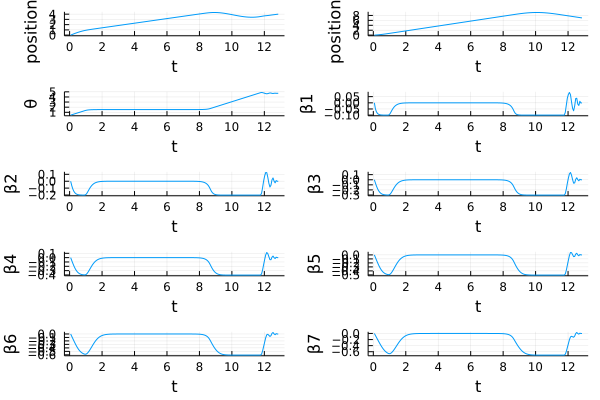

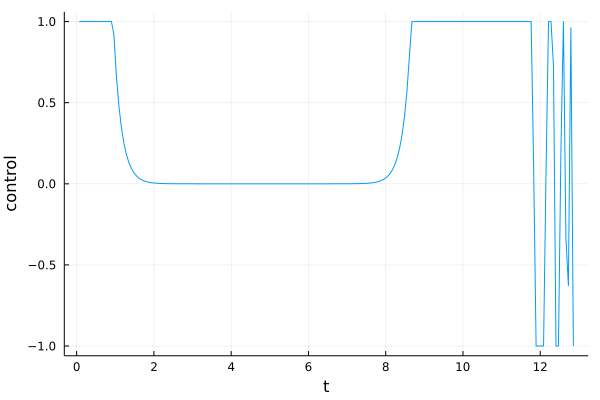

0.06478162412071063
tf = 12.857191089872137


In [4]:
#JuMP model, Ipopt solver
sys3 = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys3,"tol",1e-14)
set_optimizer_attribute(sys3,"max_iter",1000)

#Parameters

# constants
w = 0.4
l = 0.1   # l must respect the condiction : l <= 1/sqrt(N), where N is the number of segments, typically here N = 7, so 0 <= l <= 1/sqrt(7) 
μ = 10^(-4)

# function wich gives the bound for each alpha_k 

function bound(k)
    α_star = asin(l/sqrt(1-(k-1)*l^2))
    return α_star
end

# function wich gives the bound for each beta_k 

function sum_bounds(k)
    s = 0 
    for i = 1 : k 
        s+= bound(i)
    end
    return s
end


# initial data
x0 = 0 
y0 = 0 
θ0 = π/7
β1_0 = 0 
β2_0 = 0
β3_0 = 0
β4_0 = 0
β5_0 = 0
β6_0 = 0
β7_0 = 0
c0 = 0

# final data
xf = 4
yf = 7
θf = 3*π/2
β1_f = 0
β2_f = 0
β3_f = 0
β4_f = 0
β5_f = 0
β6_f = 0
β7_f = 0

P = 200
# Bounds for variables

JuMP.@variables(sys3,begin
    x[1:P]                                    # x 
    y[1:P]                                    # y 
    θ[1:P]                                    # theta
    -sum_bounds(1)≤β1[1:P]≤sum_bounds(1)      # beta1         -alpha*_i + beta_{i-1} <= beta_i <= alpha*_i + beta_{i-1}
    -sum_bounds(2)≤β2[1:P]≤sum_bounds(2)      # beta2
    -sum_bounds(3)≤β3[1:P]≤sum_bounds(3)      # beta3
    -sum_bounds(4)≤β4[1:P]≤sum_bounds(4)      # beta4
    -sum_bounds(5)≤β5[1:P]≤sum_bounds(5)      # beta5
    -sum_bounds(6)≤β6[1:P]≤sum_bounds(6)      # beta6
    -sum_bounds(7)≤β7[1:P]≤sum_bounds(7)      # beta7
    -1 ≤ u[1:P] ≤ 1                           # u, control
     0 ≤ Δt ≤ 1
    c[1:P]
    end)

# Objective
@objective(sys3,Min,Δt+μ*c[P])
# Constraints 
@constraints(sys3,begin
    x[1] == x0
    y[1] == y0
    θ[1] == θ0
    β1[1]== β1_0
    β2[1] == β2_0
    β3[1] == β3_0
    β4[1] == β4_0
    β5[1] == β5_0
    β6[1] == β6_0
    β7[1] == β7_0
    c[1] == c0
    x[P] == xf
    y[P] == yf
    θ[P] == θf
    β1[P] == β1_f
    β2[P] == β2_f
    β3[P] == β3_f
    β4[P] == β4_f
    β5[P] == β5_f
    β6[P] == β6_f
    β7[P] == β7_f
        end)

# Dynamics : Crank-Nicolson scheme
for j in 1 : P-1
    @NLconstraint(sys3, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys3, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys3, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt * (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys3, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt * (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
    @NLconstraint(sys3, #beta3' = -u - cos(beta1) * cos(beta2-beta1)*sin(beta3 - beta2)/l
        β3[j+1] == β3[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j]) * sin(β3[j] - β2[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1]) * sin(β3[j+1] - β2[j+1])/l ))
    @NLconstraint(sys3, #beta4' = -u - cos(beta1) * cos(beta2-beta1)*cos(beta3-beta2)*sin(beta4 - beta3)/l
        β4[j+1] == β4[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j])*cos(β3[j] - β2[j]) * sin(β4[j] - β3[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1])*cos(β3[j+1] - β2[j+1])* sin(β4[j+1] - β3[j+1])/l ))
    @NLconstraint(sys3, #beta5' = -u - cos(beta1) * cos(beta2-beta1)*cos(beta3-beta2)*cos(beta4-beta3)*sin(beta5 - beta4)/l
        β5[j+1] == β5[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j])*cos(β3[j] - β2[j]) *cos(β4[j]-β3[j])* sin(β5[j] - β4[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1])*cos(β3[j+1] - β2[j+1])*cos(β4[j+1]-β3[j+1])* sin(β5[j+1] - β4[j+1])/l ))
    @NLconstraint(sys3, #beta6' = -u - cos(beta1) * cos(beta2-beta1)*cos(beta3-beta2)*cos(beta4-beta3)*cos(beta5-beta4)*sin(beta6 - beta5)/l
        β6[j+1] == β6[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j])*cos(β3[j] - β2[j]) *cos(β4[j]-β3[j])*cos(β5[j]-β4[j])* sin(β6[j] - β5[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1])*cos(β3[j+1] - β2[j+1])*cos(β4[j+1]-β3[j+1])*cos(β5[j+1]-β4[j+1])* sin(β6[j+1] - β5[j+1])/l ))
    @NLconstraint(sys3, #beta7' = -u - cos(beta1) * cos(beta2-beta1)*cos(beta3-beta2)*cos(beta4-beta3)*cos(beta5-beta4)*cos(beta6-beta5)*sin(beta7 - beta6)/l
        β7[j+1] == β7[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j])*cos(β3[j] - β2[j]) *cos(β4[j]-β3[j])*cos(β5[j]-β4[j])*cos(β6[j]-β5[j])* sin(β7[j] - β6[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1])*cos(β3[j+1] - β2[j+1])*cos(β4[j+1]-β3[j+1])*cos(β5[j+1]-β4[j+1])*cos(β6[j+1]-β5[j+1])* sin(β7[j+1] - β6[j+1])/l ))
    @NLconstraint(sys3, # L2-norm regularization on the control
        c[j+1] == c[j] + 0.5 * Δt * (u[j]^2+ u[j+1]^2))
    
    
end

@NLconstraint(sys3,p_t[j = 1:(P-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 * Δt * (u[j] + u[j+1]) )


#Solve for the control and state
println("Solving...")
status = optimize!(sys3)
println("Solver status : ",status)
x1 = value.(x)
y1 = value.(y)
θ1 = value.(θ)
β_1 = value.(β1)
β_2 = value.(β2)
β_3 = value.(β3)
β_4 = value.(β4)
β_5 = value.(β5)
β_6 = value.(β6)
β_7 = value.(β7)
u1 = value.(u)
println("Cost : " , objective_value(sys3))

println("tf = ", value.(Δt)*P)

#plots : states 

Δt1 = value.(Δt)
t = (1 : P)*Δt1


x_plot = plot(t,x1,xlabel = "t", ylabel = "position x", legend = false, fmt = :png)
y_plot = plot(t,y1,xlabel = "t", ylabel = "position y", legend = false, fmt = :png)
θ_plot = plot(t,θ1,xlabel = "t", ylabel = "θ", legend = false, fmt = :png)
β1_plot = plot(t,β_1,xlabel = "t", ylabel = "β1", legend = false, fmt = :png)
β2_plot = plot(t,β_2,xlabel = "t", ylabel = "β2", legend = false, fmt = :png)
β3_plot = plot(t,β_3,xlabel = "t", ylabel = "β3", legend = false, fmt = :png)
β4_plot = plot(t,β_4,xlabel = "t", ylabel = "β4", legend = false, fmt = :png)
β5_plot = plot(t,β_5,xlabel = "t", ylabel = "β5", legend = false, fmt = :png)
β6_plot = plot(t,β_6,xlabel = "t", ylabel = "β6", legend = false, fmt = :png)
β7_plot = plot(t,β_7,xlabel = "t", ylabel = "β7", legend = false, fmt = :png)
display(plot(x_plot,y_plot,θ_plot,β1_plot,β2_plot,β3_plot,β4_plot,β5_plot,β6_plot,β7_plot,layout = (5,2)))
u_plot = plot(t,u1,xlabel = "t", ylabel = "control", legend = false, fmt = :png)
display(u_plot)

#plots : trajectory 

p = plot(x1,y1, c = :blue, lw = 3)
plot!(size=(600,600))

for i = 1 :15 : P 
    z = [x1[i] y1[i]]
    θ_p = θ1[i]
    β1_p = β_1[i]
    β2_p = β_2[i]
    β3_p = β_3[i]
    β4_p = β_4[i]
    β5_p = β_5[i]
    β6_p = β_6[i]
    β7_p = β_7[i]
    
    θ_1 =  β1_p + θ_p
    θ_2 =  β2_p + θ_p
    θ_3 =  β3_p + θ_p
    θ_4 =  β4_p + θ_p
    θ_5 =  β5_p + θ_p
    θ_6 =  β6_p + θ_p
    θ_7 =  β7_p + θ_p

    z1 = z - l*[cos(θ_1) sin(θ_1)]
    z2 = z1 - l*[cos(θ_2) sin(θ_2)]
    z3 = z2 - l*[cos(θ_3) sin(θ_3)]
    z4 = z3 - l*[cos(θ_4) sin(θ_4)]
    z5 = z4 - l*[cos(θ_5) sin(θ_5)]
    z6 = z5 - l*[cos(θ_6) sin(θ_6)]
    z7 = z6 - l*[cos(θ_7) sin(θ_7)]


    
    plot!([z[1],z1[1]], [z[2],z1[2]] ,color=:black, legend = false)
    plot!([z1[1],z2[1]], [z1[2],z2[2]], color=:black, legend = false)
    plot!([z2[1],z3[1]], [z2[2],z3[2]], color=:black, legend = false)
    plot!([z3[1],z4[1]], [z3[2],z4[2]], color=:black, legend = false)
    plot!([z4[1],z5[1]], [z4[2],z5[2]], color=:black, legend = false)
    plot!([z5[1],z6[1]], [z5[2],z6[2]], color=:black, legend = false)
    plot!([z6[1],z7[1]], [z6[2],z7[2]], color=:black, legend = false)
    
    plot!([z[1]],[z[2]],seriestype = :scatter, color =:black , legend = false)
    plot!([z1[1]],[z1[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z2[1]],[z2[2]],seriestype = :scatter, color =:black , legend = false)
    plot!([z3[1]],[z3[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z4[1]],[z4[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z5[1]],[z5[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z6[1]],[z6[2]],seriestype = :scatter, color =:black , legend = false) 

    plot!(size=(600,600))
end
current()